# Using Python to Download ECCO Datasets

**Note: This notebook was modified by Andrew Delman (updated 2023-01-12) from the tutorial on the** [ECCO-GROUP Github](https://github.com/ECCO-GROUP/ECCO-ACCESS/blob/master/PODAAC/Downloading_ECCO_datasets_from_PODAAC/Tutorial_Python3_Jupyter_Notebook_Downloading_ECCO_Datasets_from_PODAAC.ipynb) **by Jack McNelis and Ian Fenty, Version 1.1 dated 2021-06-25.**

This Jupyter notebook provides instructions and Python code for downloading a set of granules (files) for an ECCO "Dataset" hosted by PO.DAAC. The focus is on downloading datasets in the lat-lon-cap 90 (llc90) native grid of the ECCO v4 simulations, since the tutorials mostly use output on the native grid. If you're new to this grid geometry, don't worry! The ecco_v4_py package discussed in the previous tutorial will help you load the ECCO output, make computations, and plot the results while hardly needing to interact with the model grid.

The example ECCO Dataset used in this tutorial is "ECCO Sea Surface Height - Daily Mean llc90 Grid (Version 4 Release 4)" which provides daily mean sea surface height on the native llc90 grid ([10.5067/ECL5D-SSH44](https://doi.org/10.5067/ECL5D-SSH44)). 

These data can also be accessed directly through the [NASA Earthdata web interface](https://search.earthdata.nasa.gov/search?fpj=ECCO). You will need to set up a NASA Earthdata account if you do not have one already.

> Tip: if you are already familiar with Python and ECCO output, and have edited your `netrc` file as described [below](#Earthdata-Login-Requirements), you can download the [ECCO_download](https://raw.githubusercontent.com/ECCO-GROUP/ECCO-v4-Python-Tutorial/master/ECCO-ACCESS/Downloading_ECCO_datasets_from_PODAAC/ecco_download.py) module. Then import it to your code using `from ecco_download import *` and call the function `ecco_podaac_download` to start downloading. You will need to know the ShortName of the dataset you want, which you can look up using the variable lists [here](https://github.com/ECCO-GROUP/ECCO-v4-Python-Tutorial/tree/master/varlist). To see the syntax of the `ecco_podaac_download` function use `help(ecco_podaac_download)`, or see the end of this tutorial for an example.


## Getting Started

### Python Library Requirements

Most of these imports are from the Python standard library. However, you will need to install these packages into your Python 3 environment if you have not already done so:

* requests
* pandas
* xarray
* tqdm
* ecco_v4_py (see earlier Python and Python Packages tutorial)

### Earthdata Login Requirements

An account with NASA Earthdata is required. Please visit [https://urs.earthdata.nasa.gov/home](https://urs.earthdata.nasa.gov/home) to make an account and be ready with your EOSDIS login and password.

*The Earthdata Login provides a single mechanism for user registration and profile management for all EOSDIS system components (DAACs, Tools, Services). Your Earthdata login also helps the EOSDIS program better understand the usage of EOSDIS services to improve user experience through customization of tools and improvement of services. EOSDIS data are openly available to all and free of charge except where governed by international agreements.*

> **Note!**  _some Earthdata password characters may cause problems depending on your system_. To be safe, do not use any of the following characters in your password: backslash (\\), space, hash (#), quotes (single or double), or greater than (>).  Set/change your Earthdata password here: [https://urs.earthdata.nasa.gov/change_password](https://urs.earthdata.nasa.gov/change_password)

1. After creating a NASA Earthdata account, create a file called ```.netrc``` in your home directory (linux, Mac):
```
/home/<username>/.netrc
```
or ```_netrc``` (Windows):
```
C:\Users\<username>\_netrc
```

The ```netrc``` file must have the following structure and must include your Earthdata account login name and password:

```
machine urs.earthdata.nasa.gov
    login <your username>
    password <your password>
```

2. Set permissions on your ```netrc``` file to be readable only by the current user.  If not, you will receive the error "netrc access too permissive." 

```shell
$ chmod 0600 ~/.netrc
```

## Initalize Python libraries

In [1]:
import numpy as np
import pandas as pd
import requests
import shutil
import time as time

# to read and plot the downloaded NetCDF files 
# assuming ecco_v4_py package has been installed in ECCOv4-py directory
# otherwise change sys.path.append as needed
import xarray as xr
import sys
from os.path import join,expanduser
user_home_dir = expanduser('~')
sys.path.append(join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco
import matplotlib.pyplot as plt

# for concurrent simulatenous downloads
from concurrent.futures import ThreadPoolExecutor
from getpass import getpass
from http.cookiejar import CookieJar
from io import StringIO
from itertools import repeat
from pathlib import Path
from platform import system
from netrc import netrc
from os.path import basename, isfile, isdir
# progress bar
from tqdm import tqdm
# library to download files
from urllib import request

# Predict the path of the netrc file depending on os/platform type.
_netrc = join(user_home_dir, "_netrc" if system()=="Windows" else ".netrc")

> **Note: if you encounter any errors such as ModuleNotFoundError, try running conda install -c conda-forge {package_name} to install or update the required package.**  For example, given the error:
> 
> ```ModuleNotFoundError```: No module named 'xmitgcm.file_utils'
> 
> Run conda install to update the xmitgcm package:
> 
> conda install -c conda-forge xmitgcm

## Define Helper Subroutines

### Helper subroutine to log into NASA EarthData 

In [2]:
# not pretty but it works
def setup_earthdata_login_auth(url: str='urs.earthdata.nasa.gov'):
    # look for the netrc file and use the login/password
    try:
        username, _, password = netrc(file=_netrc).authenticators(url)

    # if the file is not found, prompt the user for the login/password
    except (FileNotFoundError, TypeError):
        print('Please provide Earthdata Login credentials for access.')
        username, password = input('Username: '), getpass('Password: ')
    
    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, url, username, password)
    auth = request.HTTPBasicAuthHandler(manager)
    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)

### Helper subroutines to make the API calls to search CMR and parse response

In [3]:
def set_params(params: dict):
    params.update({'scroll': "true", 'page_size': 2000})
    return {par: val for par, val in params.items() if val is not None}

def get_results(params: dict, headers: dict=None):
    response = requests.get(url="https://cmr.earthdata.nasa.gov/search/granules.csv", 
                            params=set_params(params),
                            headers=headers)
    return response, response.headers


def get_granules(params: dict):
    response, headers = get_results(params=params)
    scroll = headers['CMR-Scroll-Id']
    hits = int(headers['CMR-Hits'])
    if hits==0:
        raise Exception("No granules matched your input parameters.")
    df = pd.read_csv(StringIO(response.text)) 
    while hits > df.index.size:
        response, _ = get_results(params=params, headers={'CMR-Scroll-Id': scroll})
        data = pd.read_csv(StringIO(response.text))
        df = pd.concat([df, data])
    return df

### Helper subroutine to gracefully download single files and avoids re-downloading if file already exists.  

In [4]:
# To force redownload of the file, pass **True** to the boolean argument *force* (default **False**)
def download_file(url: str, output_dir: str, force: bool=False):
    """
    url (str): the HTTPS url from which the file will download
    output_dir (str): the local path into which the file will download
    force (bool): download even if the file exists locally already
    """
    if not isdir(output_dir):
        raise Exception(f"Output directory doesnt exist! ({output_dir})")
    
    target_file = join(output_dir, basename(url))
    
    # if the file has already been downloaded, skip    
    if isfile(target_file) and force is False:
        print(f'\n{basename(url)} already exists, and force=False, not re-downloading')
        return 0
    
    with requests.get(url) as r:
        if not r.status_code // 100 == 2: 
            raise Exception(r.text)
            return 0
        else:
            with open(target_file, 'wb') as f:
                total_size_in_bytes= int(r.headers.get('content-length', 0))
                for chunk in r.iter_content(chunk_size=1024):
                    if chunk:
                        f.write(chunk)

                return total_size_in_bytes

### Helper subroutine to download all urls in the list `dls`

In [5]:
def download_files_concurrently(dls, download_dir, force=False):
    start_time = time.time()

    # use 3 threads for concurrent downloads
    with ThreadPoolExecutor(max_workers=max_workers) as executor:

        # tqdm makes a cool progress bar
        results = list(tqdm(executor.map(download_file, dls, repeat(download_dir), repeat(force)), total=len(dls)))
    
        # add up the total downloaded file sizes
        total_download_size_in_bytes = np.sum(np.array(results))
        # calculate total time spent in the download
        total_time = time.time() - start_time

        print('\n=====================================')
        print(f'total downloaded: {np.round(total_download_size_in_bytes/1e6,2)} Mb')
        print(f'avg download speed: {np.round(total_download_size_in_bytes/1e6/total_time,2)} Mb/s')

## ECCO output structure on PO.DAAC

On the PO.DAAC Cloud, ECCO output is organized in the following hierarchy:

- **Dataset:** Typically contains a few variables, spanning the time range of the ECCO v4r4 output (currently 1992-2017). Most datasets are divided (in the time dimension) into hundreds or thousands of granules.

    - **Granule:** Dataset variables at a specific time (monthly mean, daily mean, or snapshot). Exceptions are 1-D time series where the entire dataset only consists of one granule.

        - **Variable:** A specific geophysical parameter (or flux) representing the state of the ocean, atmosphere, or sea ice/snow cover.


Each dataset has a dataset code called a `ShortName` which is used to identify it on the cloud. In order to download particular variable(s), you need to identify the `ShortName` associated with the dataset containing those variables. You can search for the variables in the linked text files below, or download these files for your reference.

### Dataset ShortNames and variables associated with them

[ECCO v4r4 llc90 Grid Dataset Variables - Monthly Means](https://raw.githubusercontent.com/ECCO-GROUP/ECCO-v4-Python-Tutorial/master/varlist/v4r4_nctiles_monthly_varlist.txt)

[ECCO v4r4 llc90 Grid Dataset Variables - Daily Means](https://raw.githubusercontent.com/ECCO-GROUP/ECCO-v4-Python-Tutorial/master/varlist/v4r4_nctiles_daily_varlist.txt)

[ECCO v4r4 llc90 Grid Dataset Variables - Snapshots](https://raw.githubusercontent.com/ECCO-GROUP/ECCO-v4-Python-Tutorial/master/varlist/v4r4_nctiles_snapshots_varlist.txt)

Note that unlike earlier releases of ECCO v4, in v4r4 all monthly mean variables are also available for download as daily means. Snapshots (typically at daily intervals) are available for a few variables, and can be used to help close budgets as shown in later tutorials.

## Download granules of an ECCO dataset falling within a specific date range

## Define dataset parameters

To download using the code below, specify the ECCO dataset `ShortName`, and a desired date range using `StartDate` and `EndDate`.  

In this example we look for the dataset containing the variable SSH, with granules matching a 7-day range (inclusive), January 1, 2000 to January 7, 2000.  Note, the granule associated with the daily-mean of December 31, 1999 matches the search because its `EndDate` is January 1, 2000.

In [6]:
# ECCO dataset ShortName
ShortName = "ECCO_L4_SSH_LLC0090GRID_DAILY_V4R4"

# desired date range
StartDate = "2000-01-01"
EndDate   = "2000-01-07"

## Define download directory

**Change the `download_root_dir` for your system!**

The download_root_dir is currently set under the user's home directory, but can also be changed to a path outside the user's home directory, e.g. download_root_dir = Path('/mnt/Downloads/ECCO_V4r4_PODAAC')

In [7]:
# define root directory for downloaded NetCDF files
download_root_dir = Path(user_home_dir + '/Downloads/ECCO_V4r4_PODAAC')

# define the directory where the downloaded files will be saved
download_dir = download_root_dir / ShortName

# create the download directory
download_dir.mkdir(exist_ok = True, parents=True)

print(f'created download directory {download_dir}')

created download directory C:\Users\adelman\Downloads\ECCO_V4r4_PODAAC\ECCO_L4_SSH_LLC0090GRID_DAILY_V4R4


## Log into Earthdata using your username and password

In [8]:
# actually log in with this command:
setup_earthdata_login_auth()

## Search NASA's "Common Metadata Repository" for the ECCO dataset

Query the NASA Common Metadata Repository to find the URL of every granule associated with the desired ECCO Dataset and date range of interest.

In [9]:
# create a Python dictionary with our search criteria:  `ShortName` and `temporal`
input_search_params = {'ShortName': ShortName,
                       'temporal': ",".join([StartDate, EndDate])}

print(input_search_params)

{'ShortName': 'ECCO_L4_SSH_LLC0090GRID_DAILY_V4R4', 'temporal': '2000-01-01,2000-01-07'}


### Query CMR for the desired ECCO Dataset

Call `get_granules` with the `input_search_params` dictionary argument. The result is a Pandas dataframe with granule metadata results in table form.

In [10]:
# grans means 'granules', PO.DAAC's term for individual files in a dataset
grans = get_granules(input_search_params)

# what did we find? --- 8 granules!
grans.info()

num_grans = len( grans['Granule UR'] )
print (f'\nTotal number of matching granules: {num_grans}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Granule UR           8 non-null      object 
 1   Producer Granule ID  0 non-null      float64
 2   Start Time           8 non-null      object 
 3   End Time             8 non-null      object 
 4   Online Access URLs   8 non-null      object 
 5   Browse URLs          0 non-null      float64
 6   Cloud Cover          0 non-null      float64
 7   Day/Night            8 non-null      object 
 8   Size                 8 non-null      float64
dtypes: float64(4), object(5)
memory usage: 704.0+ bytes

Total number of matching granules: 8


## Download the granules

In [11]:
# convert the rows of the 'Online Access URLS' column to a Python list
dls = grans['Online Access URLs'].tolist()

# the url of the first file is
print(dls[0])

https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/ECCO_L4_SSH_LLC0090GRID_DAILY_V4R4/SEA_SURFACE_HEIGHT_day_mean_1999-12-31_ECCO_V4r4_native_llc0090.nc


### Method 1: Concurrent downloads

Define the maximum number of concurrent downloads (benefits typically taper off above 5-6)

In [12]:
max_workers = 6

Execute the download command

In [13]:
# Ex 1) Force redownload if the file exists
force=True
download_files_concurrently(dls, download_dir, force)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:21<00:00,  2.73s/it]


total downloaded: 47.42 Mb
avg download speed: 2.17 Mb/s


In [14]:
# Ex 2) Do not force redownload if the file exists
force=False
download_files_concurrently(dls, download_dir, force)


SEA_SURFACE_HEIGHT_day_mean_2000-01-01_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading
SEA_SURFACE_HEIGHT_day_mean_1999-12-31_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

SEA_SURFACE_HEIGHT_day_mean_2000-01-02_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading


SEA_SURFACE_HEIGHT_day_mean_2000-01-03_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

SEA_SURFACE_HEIGHT_day_mean_2000-01-04_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

SEA_SURFACE_HEIGHT_day_mean_2000-01-07_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading


100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<?, ?it/s]


SEA_SURFACE_HEIGHT_day_mean_2000-01-05_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading
SEA_SURFACE_HEIGHT_day_mean_2000-01-06_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading


total downloaded: 0.0 Mb
avg download speed: 0.0 Mb/s


### Method 2: Sequential Downloads

Download each URL sequentially in a for loop.

In [15]:
total_download_size_in_bytes = 0
start_time = time.time()

# force file download for demonstration purposes
force = True

# loop through all urls in dls
for u in dls:
    u_name = u.split('/')[-1]
    print(f'downloading {u_name}')
    total_download_size_in_bytes += download_file(url=u, output_dir=download_dir, force=force)

# calculate total time spent in the download
total_time = time.time() - start_time

print('\n=====================================')
print(f'total downloaded: {np.round(total_download_size_in_bytes/1e6,2)} Mb')
print(f'avg download speed: {np.round(total_download_size_in_bytes/1e6/total_time,2)} Mb/s')

downloading SEA_SURFACE_HEIGHT_day_mean_1999-12-31_ECCO_V4r4_native_llc0090.nc
downloading SEA_SURFACE_HEIGHT_day_mean_2000-01-01_ECCO_V4r4_native_llc0090.nc
downloading SEA_SURFACE_HEIGHT_day_mean_2000-01-02_ECCO_V4r4_native_llc0090.nc
downloading SEA_SURFACE_HEIGHT_day_mean_2000-01-03_ECCO_V4r4_native_llc0090.nc
downloading SEA_SURFACE_HEIGHT_day_mean_2000-01-04_ECCO_V4r4_native_llc0090.nc
downloading SEA_SURFACE_HEIGHT_day_mean_2000-01-05_ECCO_V4r4_native_llc0090.nc
downloading SEA_SURFACE_HEIGHT_day_mean_2000-01-06_ECCO_V4r4_native_llc0090.nc
downloading SEA_SURFACE_HEIGHT_day_mean_2000-01-07_ECCO_V4r4_native_llc0090.nc

total downloaded: 47.42 Mb
avg download speed: 1.08 Mb/s


## Check downloads

Get the list of files:

In [16]:
ecco_netcdf_files = list(download_dir.glob('*nc'))

print(f'number of downloaded files {len(ecco_netcdf_files)}')

number of downloaded files 8


## Plotting llc90 grid output on a global lon-lat map

Now open and combine all NetCDF files together using the `xarray.open_mfdataset` function:

In [17]:
xds = xr.open_mfdataset(ecco_netcdf_files, parallel=True, data_vars='minimal',\
                                  coords='minimal', compat='override')

print(xds)

<xarray.Dataset>
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, tile: 13, time: 8, nv: 2, nb: 4)
Coordinates: (12/13)
  * i          (i) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j          (j) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 1999-12-31T12:00:00 ... 2000-01-07T12:00:00
    ...         ...
    YC         (tile, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    XG         (tile, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YG         (tile, j_g, i_g) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    time_bnds  (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    XC_bnds    (tile, j, i, nb) float32 dask

In [18]:
# select variable to plot from dataset
var_to_plot = 'SSH'
dataarray_plot = eval('xds.' + var_to_plot)

# compute the time mean over the downloaded files
time_mean = dataarray_plot.mean('time').compute()

20.125 179.875
20.0 180.0
-89.875 89.875
-90.0 90.0
-179.87484356070087 19.874833560700864
-180.0 19.99999
-89.875 89.875
-90.0 90.0


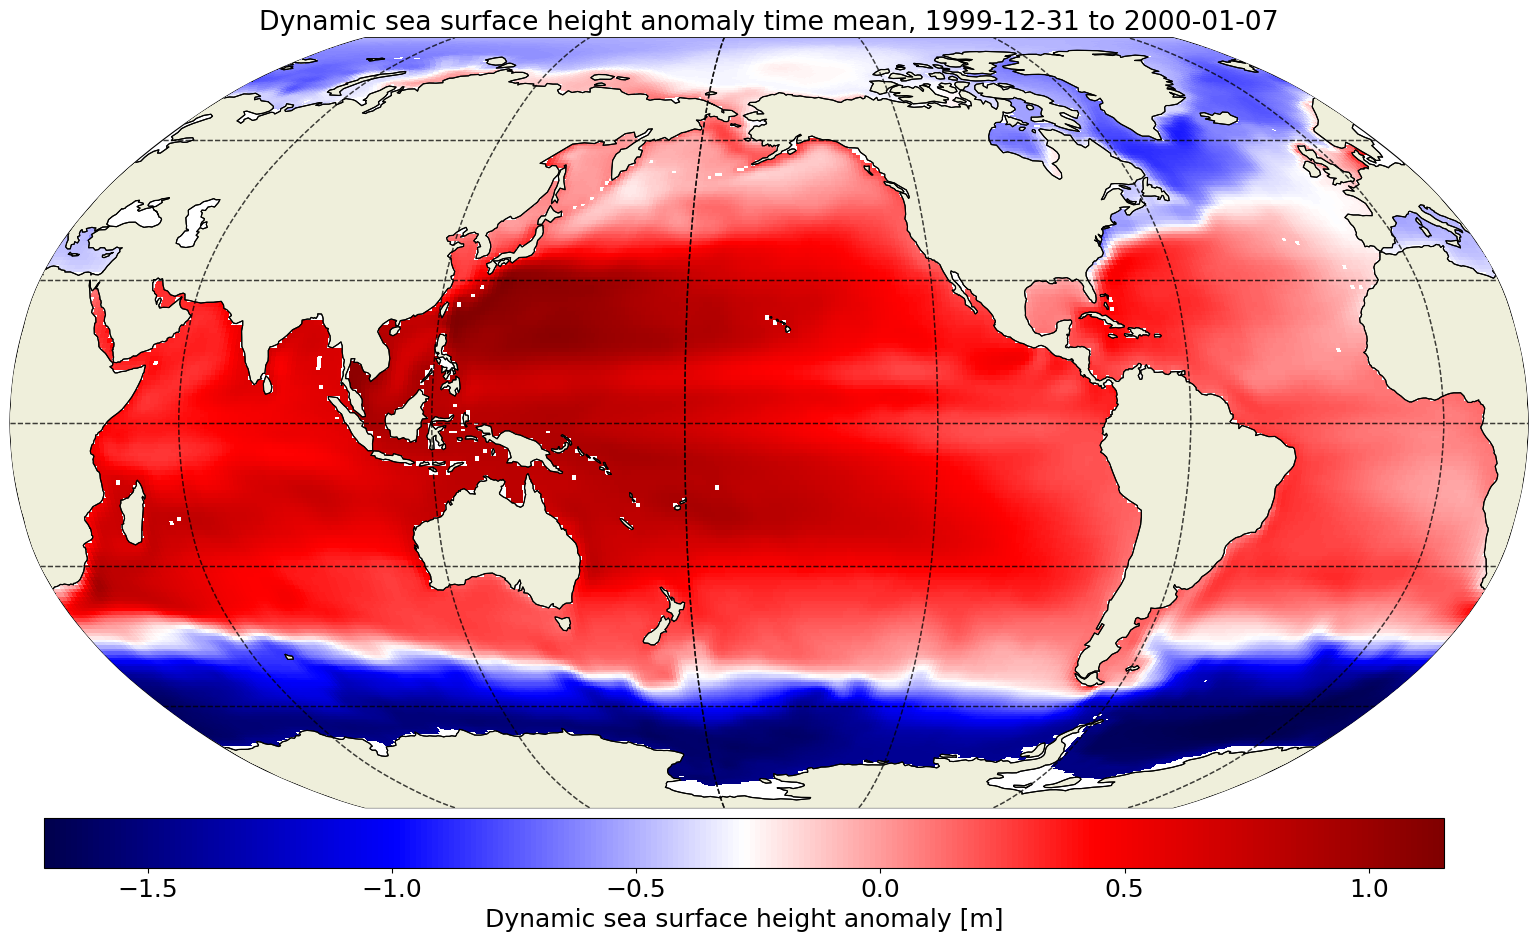

In [19]:
# use ecco_v4_py function to plot native grid data on lat-lon map
plt.rcParams["font.size"] = 16
fig = plt.figure(figsize=[20,10])
time_values = dataarray_plot.time.data
title_str = dataarray_plot.long_name + ' time mean, ' + str(time_values[0])[:10] + ' to ' + str(time_values[-1])[:10]
# scalar quantities generally have coordinates XC and YC for longitude and latitude respectively
# vectors (e.g. velocities, fluxes) have different coordinates; see Coordinates tutorial for more detail
plot_obj = ecco.plot_proj_to_latlon_grid(dataarray_plot.XC, dataarray_plot.YC, time_mean, show_colorbar=False, user_lon_0=200, cmap='seismic')
plt.title(title_str)
# create horizontal colorbar with label
cax = plt.axes([0.15,0.05,0.7,0.05])
cbar = plt.colorbar(plot_obj[2],cax=cax,orientation='horizontal')
cbar.set_label(dataarray_plot.long_name + ' [' + dataarray_plot.units + ']',fontsize=18)
cax.tick_params(labelsize=18)

20.125 179.875
20.0 180.0
-89.875 89.875
-90.0 90.0
-179.87484356070087 19.874833560700864
-180.0 19.99999
-89.875 89.875
-90.0 90.0


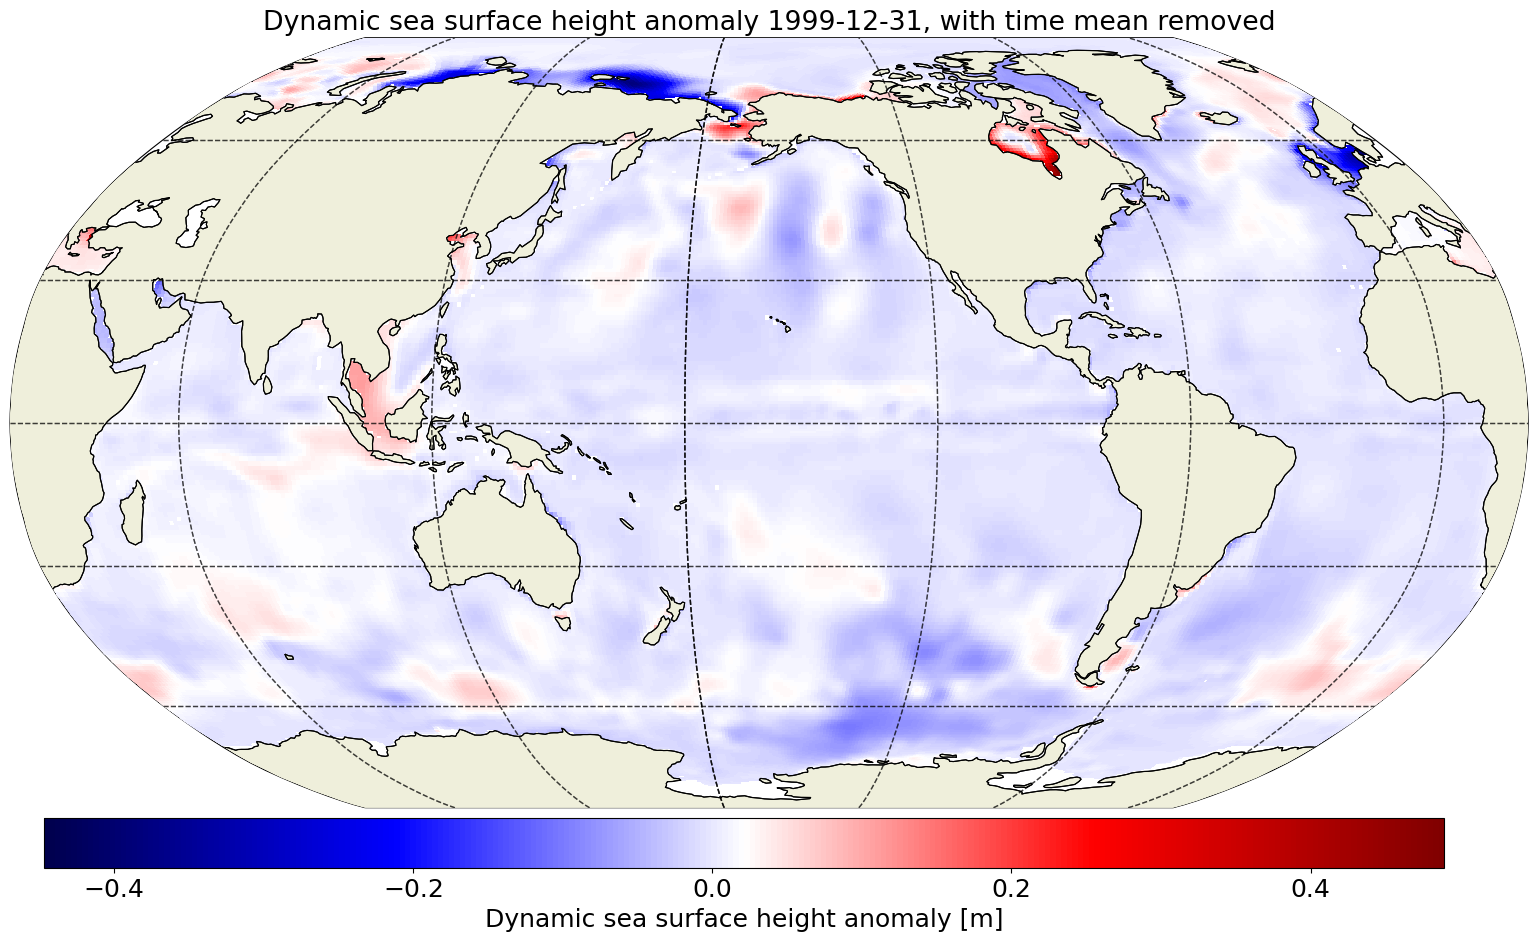

In [20]:
# Plot the anomaly of the first record (time_ind = 0) relative to the time mean
time_ind = 0
fig = plt.figure(figsize=[20,10])
title_str = dataarray_plot.long_name + ' ' + str(time_values[time_ind])[:10] + ', with time mean removed'
plot_obj = ecco.plot_proj_to_latlon_grid(dataarray_plot.XC, dataarray_plot.YC, dataarray_plot.isel(time=time_ind) - time_mean, show_colorbar=False, user_lon_0=200, cmap='seismic')
plt.title(title_str)
cax = plt.axes([0.15,0.05,0.7,0.05])
cbar = plt.colorbar(plot_obj[2],cax=cax,orientation='horizontal')
cbar.set_label(dataarray_plot.long_name + ' [' + dataarray_plot.units + ']',fontsize=18)
cax.tick_params(labelsize=18)

## ECCO_download module

If you've made it this far, that means you can now download and plot any available ECCOv4r4 variable on your local machine. Woohoo! But to make it easier in the future, you can also download the following Python module that runs the downloading routines contained in this notebook.

[ecco_download module](https://raw.githubusercontent.com/ECCO-GROUP/ECCO-v4-Python-Tutorial/master/ECCO-ACCESS/Downloading_ECCO_datasets_from_PODAAC/ecco_download.py)

You can save this file either in the same directory where you store the tutorial notebooks, or a different directory that you then add to your path using sys.path.append. Then you can download using the `ecco_podaac_download` function. To see the syntax of how this is used, let's invoke the module to download daily SSH data for the week 2000-01-08 to 2000-01-14:

In [21]:
from ecco_download import *

ecco_podaac_download(ShortName="ECCO_L4_SSH_LLC0090GRID_DAILY_V4R4",\
                    StartDate="2000-01-09",EndDate="2000-01-14",download_root_dir=None,\
                    n_workers=6,force_redownload=False)

created download directory C:\Users\adelman\Downloads\ECCO_V4r4_PODAAC\ECCO_L4_SSH_LLC0090GRID_DAILY_V4R4
{'ShortName': 'ECCO_L4_SSH_LLC0090GRID_DAILY_V4R4', 'temporal': '2000-01-09,2000-01-14'}

Total number of matching granules: 7


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:21<00:00,  3.12s/it]


total downloaded: 41.48 Mb
avg download speed: 1.9 Mb/s
